# Replicating the binary string model (Hong & Page 2001)

Reijula & Kuorikoski (2020)

Simulating the binary string model, reconstruction based on Hong & Page 2001. 

Our aim was to examine whether we find the diversity-beats-ability phenomenon in this model (not only in the simplified model described in Hong & Page 2004)

In [155]:
# IMPORTS
import sys
import numpy as np
import pandas as pd

import logging
logging.basicConfig()

#MATPLOTLIB
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [156]:
def spinning_cursor():
    while True:
        for cursor in '|/-\\':
            yield cursor

sc = spinning_cursor()

def update_spinner():
    sys.stdout.write('\b')
    sys.stdout.write(next(sc))
    sys.stdout.flush()

update_spinner()

|

In [22]:
def printstring( size , bitstring ):
    """
    return a bit string representation of a bitstring
    """
    bits = size #how many bits to show in the string
    return format( bitstring, f'0{bits}b' )
    
# test output:
print( printstring( 4 , 7 ) )
print( printstring( 5 , 0b001 ) ) 

0111
00001


In [25]:
def numDuplicates( array ):
    """
    how many duplicates in an array
    """
    return ( len( array ) - len( np.unique( array ) ) )

# tests
temp1 = np.array( [1,1,1,3,3,4] )
temp2 = np.array( [-1,0,3,4,5] )
assert numDuplicates( temp1 ) == 3, "should be 3"
assert numDuplicates( temp2 ) == 0, "should be 0"

In [33]:
def flipBit( target , mask ):
    """
    xor (target, mask) --> flip bits in target which  are 1s in the mask
    """
    return target ^ mask 

# tests
a = np.random.randint(7)
assert flipBit( flipBit(a , a) , a) == a , "double flip"

### Value functions

In [43]:
def countOnes( target ):
    """
    return number of 1-bits in a bitstring
    """
    targetStr = format( target, f'0b' )
    targetList = [ int(i) for i in list(targetStr) ]
    return sum( targetList )

countOnesVec = np.vectorize(countOnes) # vectorized version of countOnes, can be applied to numpy arrays

# tests
testArray = np.array([ 0b001, 0b1111 , 0b101 ])
assert (countOnesVec(testArray) == np.array([1 , 4 , 2])).all() , "ok"

In [70]:
def create_V( size , ls ):
    """
    Returns the value function. 
    - size: length of bitstring (bits)
    - ls: type of problem (simple etc.)
    - (C) RANDOM: fully random value function (most difficult possible)
    
    """
    
    logger = logging.getLogger( 'init_landscape' )
    logger.setLevel( logging.WARNING )
    
    strings = list( range( 2 ** size ) ) # list of bit positions
    
    if ls=='random':
        s = np.array( strings )
        np.random.shuffle( s ) # payoffs = shuffled list of strings ...
        payoffs = list( s ) 
        
    # CREATE PANDAS DF WITH SOLUTIONS AS THE INDEX --> FAST INDEXING
    df = pd.DataFrame( {'solution':strings , 'payoff':payoffs} )
    df = df.set_index( 'solution' )
    df.payoff = df.payoff - df.payoff.max() #normalize so that max payoff is 0

    logger.debug( f"String consisting of zeros, payoff: {df.loc[0b0].payoff}" ) #remember: .iloc accesses by row number
    logger.debug( df )
    
    return df

# tests
test_df = create_V( 3 , 'random' )
min_payoff = test_df.payoff.min()
assert np.sum(test_df.index) == np.sum( (test_df.payoff - min_payoff) ) , "make sure the sums match"

# MASKS

In [91]:
# full search

def randomString( size ):
    return np.random.randint( 2 ** size )

def randomMask( size ):
    return np.random.randint( 2 ** size )

# tests: 
randString = randomString( 3 )
print( f'{randString} aka {format( randString , f"04b" )}' )

7 aka 0111


In [92]:
class P:
    MAX_ROUNDS = 1000 # how many trials can the simulation run

In [116]:
class Agent():
    
    def __init__( self , size , coversize , fset_set_size , random ):
        """
        returns a new agent: 
        - size: length of bitstring 
        - coversize: largest cover of a flipset in the heuristic (see below for implementation detail)
        - fset_set_size: how many flipsets in the heuristic 
        - random: if True, heuristic consists of full-size random heuristics. ignore coversize parameter
        
        """
        
        self.score = np.zeros( P.MAX_ROUNDS )
        self.performance = 0 # expected score from several trials on a landscape
        self.size = size # what's the size of the bitstring you're solving
        self.fset_set_size = fset_set_size
        
        flipsets = []
        
        if random==False:
            for i in range( fset_set_size ): 
                flipsets.append( Agent.generate_flipset( self.size , coversize ) )
        else:
            for i in range( fset_set_size ):
                flipsets.append( randomMask( self.size ) )
                
        self.set_flipsets( np.array(flipsets) )
        
        
    def generate_flipset( size , coversize ):
        """
        generates  coversize-sized flipsets (set size: fset_set_size) --> flipset heuristic of the agent 
        """
        
        a = np.arange( start=0 , stop=size , step=1 , dtype=int )
        flipped_bit_indices = np.random.choice( a , size=coversize , replace=False ) # draw bit indices WITHOUT replacement

        # use indices to switch on bits in the mask
        mask = 0
        for i in list( flipped_bit_indices ):
            mask += 2 ** i
        
        return mask
        
        
    def set_flipsets( self , flipsets ):
        self.flipsets = flipsets
    
    
    def make_group_agent( agent_list ):
        """
        combine flipset heuristics from agents in agent_list into one superagent 
        
        """
        
        new_flipsets = np.zeros( (0) , dtype=int ) # store here the flipset set (which grows in size over iterations)
        max_cover = 0
        
        size = agent_list[0].size # length of the bitstring , steal the info from first agent in agent_list
        
        for a in agent_list: 
            new_flipsets = np.hstack( (new_flipsets , a.flipsets) ) #merge flipsets
        
        new_agent = Agent( size , max_cover , len(new_flipsets) , random=False ) # agent w/ dummy flipsets
        new_agent.set_flipsets( new_flipsets ) 
        
        new_agent.coversize = np.max( countOnesVec( new_flipsets ) ) # find largest cover size in new flipset-h
        
        return new_agent

    
    def print_flipsets( self ):
        bitstring_string = [ printstring( self.size , i ) for i in list(self.flipsets) ]
        print( bitstring_string )
        

### TESTS
test_flipset = Agent.generate_flipset( size=5 , coversize=4 )
print( f'flipset of size, cover 4: {format( test_flipset, f"05b" )}\n' )


a = Agent( size=4 , coversize=1 , fset_set_size=3 , random=False ) #remember, params: <size , coversize , fset_set_size , random>
b = Agent( size=4 , coversize=2 , fset_set_size=4 , random=False )

c = Agent.make_group_agent( [a,b] )

print(f'agent a:')
a.print_flipsets()

print(f'agent b:')
b.print_flipsets()

print(f'agent c:')
c.print_flipsets()

print(f'cs coversize: { c.coversize }' )
print(f'cs fset_set_size { c.fset_set_size }' )


print()
f = Agent( size=7, coversize=0 , fset_set_size=4 , random=True ) # here value of coversize is ignored

print(f'random mask agent:')
f.print_flipsets()

flipset of size, cover 4: 11011

agent a:
['1000', '0100', '0001']
agent b:
['0110', '1001', '0011', '1100']
agent c:
['1000', '0100', '0001', '0110', '1001', '0011', '1100']
cs coversize: 2
cs fset_set_size 7

random mask agent:
['0101111', '0000000', '1110010', '1010101']


In [122]:
def game( n , value_function , flipsets ):
    """
    run one game:
    - n: length of bitstring 
    - value_function: the used value function 
    - flipsets: flipset heuristic applied to the problem 
    
    - return a list: (time, payoff, scores)
    
    - properties (from Hong & Page 2001 whenever applicable):
      - application order of flipsets shuffled each time 
      - search starts from a random string
      - switch to a new solution only if strictly higher payoff
    
    """
    
    # set up logging for debug
    logger = logging.getLogger( 'simu' )
    logger.setLevel(logging.WARNING) #set level to DEBUG for testing
    
    # init
    time = 0
    fset_index = 0 #index variable for looping through the different flipsets in the set
    stop = False
    scores = np.zeros( P.MAX_ROUNDS )
    
    # shuffle flipsets before applying
    random_flipsets = np.copy( flipsets ) # make a deep copy of original flipset heuristic so that it doesn't get scrambled
    np.random.shuffle( random_flipsets ) # shuffle the application order of flipsets 
    fset_size = len( random_flipsets )
    
    # choose a random string as starting position
    solution = np.random.choice( value_function.index ) 
    payoff = value_function.loc[ solution ].payoff
    
    logger.debug( "flipsets: "+ str( [printstring( n , i ) for i in random_flipsets] ) ) 
    logger.debug( '\n' )
    logger.debug( "starting position: "+ printstring( n , solution ) )
    logger.debug( "payoff at starting position: "+ str( payoff ) )
    logger.debug( f'flipset size: {fset_size}' )
    logger.debug( 'GO\n' )
    
    while not stop: # loop until local/global maximum reached
        flipset = random_flipsets[ fset_index ]
        scores[ time ] = payoff # store the time series of scores
        
        # apply the next flipset, switch if better than current
        solutionCandidate = flipBit( solution , flipset )
        candidatePayoff = value_function.loc[ solutionCandidate ].payoff
        
        logger.debug( f'time: {time}' )
        logger.debug( f'current string: {printstring( n , solution )}')
        logger.debug( f'fset_index: {fset_index}' )
        logger.debug( f'flipset: {printstring( n , flipset )}' )
        logger.debug( f'solutioncandidate: {printstring( n , solutionCandidate )}' )
        logger.debug( f'payoff of solution candidate: {candidatePayoff}' )
        
        if candidatePayoff > payoff:
            solution = solutionCandidate
            payoff = candidatePayoff
            logger.debug( 'switching' )
        
        # end of round updating
        time += 1
        fset_index += 1
        logger.debug('\n')
        
        # if last flipset reached --> loop back to beginning of set of flipsets 
        if fset_index == fset_size:
            fset_index = 0
        
        # if scores have not improved since the previous round of applying flipsets, stop
        if time > fset_size:
            if payoff == scores[time-fset_size]:
                stop = True

    logger.debug( f'Final solution: {printstring( n , solution )}' )
    logger.debug( f'Elapsed rounds: {time}' )
    
    return time, payoff, scores


# for testing, set debugger to DEBUG

n = 4
flipsets_per_agent = 4
a = Agent( n , 0 , flipsets_per_agent , random=True )
a.print_flipsets()

landscape = create_V( n , 'random' )
print(landscape)

time, payoff, scores = game( a.size , landscape , a.flipsets )

a.print_flipsets()

['1001', '0010', '0101', '1001']
          payoff
solution        
0             -6
1            -11
2             -5
3            -10
4            -15
5            -12
6             -7
7             -3
8             -4
9             -2
10           -14
11            -1
12            -9
13            -8
14             0
15           -13
['1001', '0010', '0101', '1001']


In [141]:
def calc_performance( agent , v_func , reps ):
    """
    play #reps games with a particular v_func, and a particular (super)agent
    return a dict with mean&sd of end_times and end_payoffs
    - note: across trials, space remains the same but starting position & application order of flipsets are both random
    """
    
    # SET UP LOGGING FOR DEBUG
    logger = logging.getLogger( 'calc_perf' )
    logger.setLevel(logging.WARNING) #set level to DEBUG for testing
    
    end_times = pd.Series( reps )
    end_payoffs = pd.Series( reps )
    
    for i in range( reps ):
        end_times[i] , end_payoffs[i] , score_timeseries = game( agent.size , v_func , agent.flipsets ) #throwing away the timeseries
        logger.debug( f'end time: {end_times[i]}' )
        logger.debug( f'end payoff: {end_payoffs[i]}' )                    
            
    return { 
            'time_mean':end_times.mean() , 
            'time_sd':end_times.std() , 
            'payoff_mean':end_payoffs.mean() , 
            'payoff_sd':end_payoffs.std() 
            }


# tests

n = 8
flipsets_per_agent = 4
a = Agent( n , 0 , flipsets_per_agent , random=True )
landscape = create_V( n , 'random' )

results_dict = calc_performance ( a , landscape , 10 )

print(results_dict)

{'time_mean': 5.5, 'time_sd': 0.7071067811865476, 'payoff_mean': -35.9, 'payoff_sd': 27.977967522081848}


## Experiment 1: The no-diminishing-marginal-utility thesis 
- for context, see Hong & Page 2001

In [146]:
### LOCAL PARAMS ###

n = 20 #length of bitstring
flipsets_per_agent = 3
max_group_size = 10
reps = 1000 


### CREATE AGENTS ###

# make a group of individual agents
a_list = []
for g in range( max_group_size ):
    a_list.append( Agent( n , 0 , flipsets_per_agent , random=True ) ) ### 0 is cover size parameter, ignored when random=True

# make group-agents of different sizes 1-->
groups = []
for g in range( max_group_size ):
    groups.append( {'size':(g+1) , 'agent':Agent.make_group_agent( a_list[:(g+1)] ) } ) #it's a dict...

assert groups[max_group_size-1]['agent'].fset_set_size == max_group_size*flipsets_per_agent # sanity check


### SIMULATE ###

group_times = []
group_times_sd = []

group_payoffs = []
group_payoffs_sd = []

group_sizes = []

landscape = create_V( n , 'random' ) # in this exp, all groups play on the same landscape

for g in groups:
    results = calc_performance( g['agent'] , landscape , reps )
    
    group_times.append( results['time_mean'] )
    group_times_sd.append( results['time_sd'] )
    
    group_payoffs.append( results['payoff_mean'] )
    group_payoffs_sd.append( results['payoff_sd'] ) 
    
    group_sizes.append( g['size'] )


group_data = pd.DataFrame( {'group_size':group_sizes , 
                            'time':group_times , 
                            'time_sd':group_times_sd, 
                            'payoff':group_payoffs, 
                            'payoff_sd':group_payoffs_sd} 
                         )

group_data


LET'S SIMULATE:



,group_size,time,time_sd,payoff,payoff_sd
0,1,4.982,1.310494,-185948.565,163166.617712
1,2,10.115,3.357238,-98255.107,89725.473291
2,3,15.442,5.232018,-69897.416,66336.661245
3,4,20.527,7.016017,-57333.770,55722.923747
4,5,25.908,9.112990,-42588.995,42285.293870
5,6,31.270,11.273961,-36125.021,35702.082557
6,7,36.755,12.663860,-30532.653,31397.933025
7,8,41.552,14.628373,-27041.546,27225.323766
8,9,47.033,15.645917,-24124.477,25446.687026
9,10,53.287,18.421943,-21476.349,21327.648838


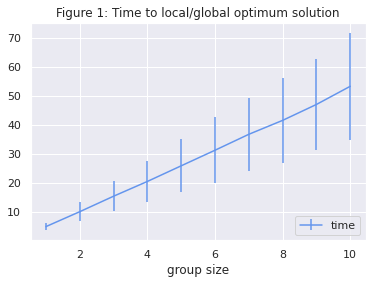

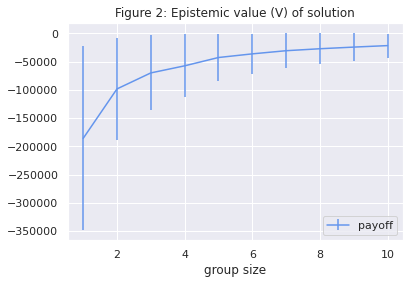

In [147]:
# VISUALIZE

fig1  = group_data.plot( legend=True , x='group_size' , 
                        y='time' , yerr='time_sd' , color='cornflowerblue' ,
                        title='Figure 1: Time to local/global optimum solution'
                       ).get_figure()

fig2 = group_data.plot( legend=True , x='group_size' , 
                        y='payoff' , yerr='payoff_sd' , color='cornflowerblue' ,
                        title='Figure 2: Epistemic value (V) of solution' 
                      ).get_figure()

fig1.get_axes()[0].set_xlabel('group size')
fig2.get_axes()[0].set_xlabel('group size')
fig1.get_axes()[0].legend(loc='lower right')
fig2.get_axes()[0].legend(loc='lower right')

fig1.savefig( 'exp1_time_to_solution.png' )
fig2.savefig( 'exp1_payoff_at_solution.png' )

## Experiment 2: Does diversity beat ability in the binary string model?

In [166]:
### LOCAL PARAMS ###

n = 20 #length of bitstring
flipsets_per_agent = 3

min_group_size = 1
max_group_size = 10

reps = 500 
tournament_size = 1000

v_function_reps = 10 

### ### ###

# SET UP LOGGING FOR DEBUG
logger = logging.getLogger( 'exp2' )
logger.setLevel(logging.WARNING) #set level to DEBUG for testing

### CREATE AGENTS ###
agents = []
for g in range( tournament_size ):
    agents.append( Agent( n , 999 , flipsets_per_agent , random=True ) ) ### 999 is cover size parameter, ignored when random=True


### SIMULATE ###

dfs = [] # a list of dataframes
    
for v in range( v_function_reps ): #repeat the whole thing over different landscapes

    landscape = create_V( n , 'random' ) 

    logger.debug(f'\nTOURNAMENT {v} \n')

    performance_list = []

    for a in agents:
        results = calc_performance( a , landscape , reps )
        performance_list.append( ( results[ 'payoff_mean' ] , a ) ) # make a list of payoffs and agents
        update_spinner()

    sorted_list = sorted( performance_list , key=lambda x: x[0] , reverse=True ) # sorted list of agent performance

    logger.debug(f'10 best agent scores { [ x[0] for x in sorted_list[:10] ] }')
    logger.debug(f'10 worst agent scores { [ x[0] for x in sorted_list[-10:] ] }')
    logger.debug(f'10 random agent scores { [ x[0] for x in performance_list[:10] ] }')
    
    logger.debug(f'\n10 best agent flipset heuristics:')
    for age in [ x[1] for x in sorted_list[:10] ]:
        logger.debug(age.flipsets)
         
    logger.debug(f'\n10 worst agent flipset heuristics:')
    for age in [ x[1] for x in sorted_list[-10:] ]:
        logger.debug(age.flipsets)
    
    logger.debug(f'\n10 random agent flipset heuristics:')
    for age in [ x[1] for x in performance_list[:10] ]:
        logger.debug(age.flipsets)
    
    # RUN WITH DIFFERENT GROUP SIZES
    random_group_performance = []
    super_group_performance = []

    group_size = min_group_size
    group_sizes = []

    while group_size <= max_group_size:
        #logger.debug( f'working on it ... group size {group_size}' )
        group_sizes.append(group_size)

        # RANDOM GROUP
        random_agent_list = performance_list[:group_size] # simply take k first agents, they're not sorted anyway, no bias.  
        random_agents = [ x[1] for x in random_agent_list ] # x[1] is the reference to the agent
        random_agent_scores = [ x[0] for x in random_agent_list ] 
        #logger.debug( f'random group agent scores:\n{ random_agent_scores }\n' )

        random_group = Agent.make_group_agent( random_agents ) # the group of #group_size random agents from the tournament
        #logger.debug(f'random group number of duplicate heuristics: { numDuplicates( random_group.flipsets ) }' )
        
        results = calc_performance( random_group , landscape , reps ) # let the random group play 
        random_group_performance.append( results['payoff_mean'] )
        #logger.debug( f'random group performance: {random_group_performance}\n' )   

        # SUPERGROUP 
        best_agents = [ x[1] for x in sorted_list[:group_size] ]
        best_agent_scores = [ x[0] for x in sorted_list[:group_size] ]
        #logger.debug( f'best-performing individual agents:\n{ best_agent_scores }\n' )

        super_group = Agent.make_group_agent( best_agents ) # the group of #group_size best-performing agents from the tournament
        #logger.debug(f'supergroup number of duplicate heuristics: { numDuplicates( super_group.flipsets ) }\n' )
        results = calc_performance( super_group , landscape , reps ) # let the supergroup play 
        super_group_performance.append( results['payoff_mean'] )
        #logger.debug( f'supergroup performance: {super_group_performance}\n' )

        group_size += 1

    # SAVE RESULTS:
    df = pd.DataFrame( {'group_size':group_sizes , 
                        'random_group':random_group_performance , 
                        'supergroup':super_group_performance} 
                     )

    dfs.append(df) # add the dataframe to the list


|

In [167]:
dfs

[   group_size  random_group  supergroup
 0           1   -173780.448 -184802.700
 1           2   -102226.886 -104232.110
 2           3    -72447.036  -69707.362
 3           4    -51091.960  -51447.156
 4           5    -44919.914  -41842.914
 5           6    -36439.712  -35784.318
 6           7    -31288.898  -32609.922
 7           8    -27789.792  -27445.192
 8           9    -22092.404  -22393.928
 9          10    -20525.950  -22495.196,
    group_size  random_group  supergroup
 0           1   -191732.280 -177454.438
 1           2   -104958.224  -99532.760
 2           3    -73591.176  -69067.370
 3           4    -53481.304  -54623.890
 4           5    -44544.852  -41342.392
 5           6    -36064.040  -33025.658
 6           7    -31258.296  -30890.830
 7           8    -27699.454  -27320.324
 8           9    -23837.014  -24506.704
 9          10    -22167.938  -20251.282,
    group_size  random_group  supergroup
 0           1   -176744.072 -190631.630
 1           2

In [168]:
# concat dataframes and save as csv 

from datetime import datetime

now = datetime.now() # current date and time
dateStr = now.strftime("d_%Y_%m_%d_h_%H")

concat_frame = pd.concat( dfs )

fileName = 'exp2_concatenated_' + dateStr + '.csv' 
print(fileName)
concat_frame.to_csv( path_or_buf=fileName , sep=',', header=True , index=False )

exp2_concatenated_d_2021_01_06_h_17.csv


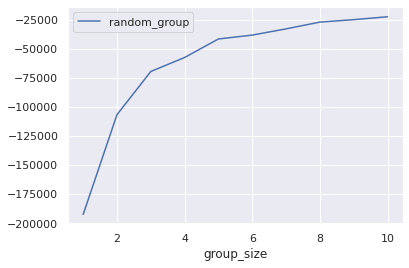

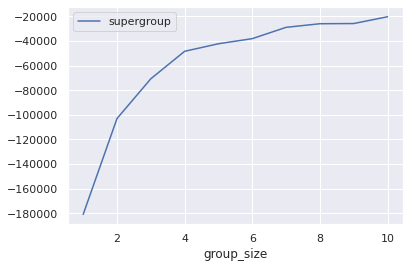

In [160]:
# sanity check: what happens in the first df

dataf = dfs[0]

fig1  = dataf.plot( legend=True , x='group_size' , 
                    y='random_group').get_figure()
fig2  = dataf.plot( legend=True , x='group_size' , 
                    y='supergroup').get_figure()

reading from file: exp2_concatenated_d_2021_01_06_h_17.csv


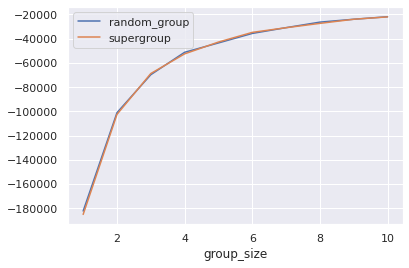

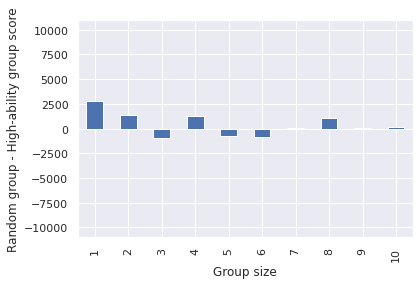

In [170]:
# combine and average over the trials from the different landscapes

print( f'reading from file: {fileName}' )
new_frame = pd.read_csv(fileName , sep=',' )

grouped = new_frame.groupby(['group_size']).mean()

grouped['dif'] = grouped.random_group - grouped.supergroup # new col: difference between random and supergroup performance

fig1 = grouped['random_group'].plot(legend = True).get_figure()
fig2 = grouped['supergroup'].plot(legend = True).get_figure()

fig3 = grouped.plot( legend=False, y='dif' , kind='bar' ).get_figure()

fig3.get_axes()[0].set_xlabel('Group size')
fig3.get_axes()[0].set_ylabel('Random group - High-ability group score')
fig3.get_axes()[0].set_ylim((-11000,11000))

plotName = dateStr + '_supergroups_vs_random_groups.png' 
fig3.savefig( plotName )


reading from file: exp2_concatenated_d_2021_01_06_h_17.csv
bitstring_super-random_d_2021_01_06_h_17.png


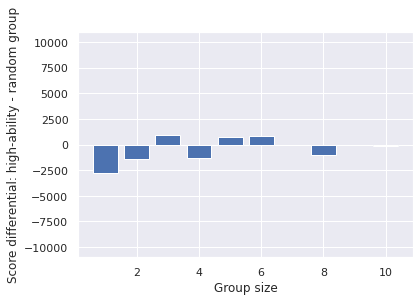

In [169]:
# combine and average over the trials from the different landscapes

# fileName = 'exp2_concatenated_d_2020_10_19_h_12.csv' # remember to update fileName
print( f'reading from file: {fileName}' )

new_frame = pd.read_csv( fileName , sep=',' )

grouped = new_frame.groupby( ['group_size'] , as_index=False ).mean()

grouped['dif'] = grouped.supergroup - grouped.random_group # new col: difference between random and supergroup performance

plt.figure()

plt.bar( grouped['group_size'] , grouped['dif'] )
plt.ylim( (-11000,11000) )

plt.xlabel(r'Group size')
plt.ylabel('Score differential: high-ability - random group')

plt.tight_layout() # prevents ylabel from being cut off

plotName = 'bitstring_super-random_' + dateStr + '.png'

print(plotName)
plt.savefig(plotName)
plt.show()